**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources such as: [Python for data science](https://www.pythonfordatascience.org/mixed-effects-regression-python/) and [Everton Gomede](https://medium.com/the-modern-scientist/understanding-hierarchical-linear-modeling-hlm2-a-multi-level-approach-to-data-analysis-06c3d27588b6). Every effort has been made to trace copyright holders of the materials used in this notebook. The author apologizes for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

In [19]:
import pip
pip.main(['install','researchpy'])

0

# Hierarchical Regression Models

Mixed effects regression is an extension of the general linear model (GLM) that takes into account the hierarchical structure of the data. Mixed effect models are also known as multilevel models, hierarchical models, mixed models (or specifically linear mixed models (LMM)) and are appropriate for many types of data such as clustered data, repeated-measures data, longitudinal data, as well as combinations of those three

**Fixed-effect parameters** describe the relationships of the covariates to the dependent variable for an entire population, **random effects** are specific to clusters of subjects within a population.

**Fixed factors** are the independent variables that are of interest to the study, e.g. treatment category, sex or gender, categorical variable, etc.
**Random factors** are the classification variables that the unit of anlaysis is grouped under, i.e. these are typically the variables that define level 2, level 3, or level n. These factors can also be thought of as a population where the unit measures were randomly sampled from, i.e. (using the school example from above) the school (level 2) had a random sample of students (level 1) scores selected to be used in the study.
Gelman & Hill (2007) make the case that the classification of a variable as a fixed effect or random effect will vary depending on the objective of the study and the analysis. How a variable is modeled changes what is being measured and what the model is assuming about the variable itself. Using the school study example, if one were to model the categorical school variable as a fixed effect that model would assume the group means (one from each school) are independent from each other; if the categorical school variable is modeled as a random effect (random intercept only) the model would assume that the schools measured are a sample of a larger population of schools.

Earlier it was mentioned how mixed-effect models could be a **random intercept model**, **random slope model**, or a **random intercept and random slope model**. With the differences being the random intercept model allows different intercepts based on the clustering variable while the random slope model allows different slopes based on a variable, and while the random intercepts and random slopes model allows different intercepts based on a clustering variable and slopes based on a variable.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import researchpy as rp
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf

## Ejemplo 1

In [2]:
df = pd.read_csv("http://www-personal.umich.edu/~bwest/rat_pup.dat", sep = "\t")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pup_id     322 non-null    int64  
 1   weight     322 non-null    float64
 2   sex        322 non-null    object 
 3   litter     322 non-null    int64  
 4   litsize    322 non-null    int64  
 5   treatment  322 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 15.2+ KB


In [3]:
rp.summary_cont(df.groupby(["treatment", "sex"])["weight"])

N    Mean      SD      SE  95% Conf.  Interval
treatment sex                                                    
Control   Female  54  6.1161  0.6851  0.0932     5.9291    6.3031
          Male    77  6.4710  0.7538  0.0859     6.3000    6.6421
High      Female  32  5.8516  0.6002  0.1061     5.6352    6.0680
          Male    33  5.9185  0.6909  0.1203     5.6735    6.1635
Low       Female  65  5.8375  0.4505  0.0559     5.7259    5.9492
          Male    61  6.0251  0.3803  0.0487     5.9277    6.1225

<Figure size 800x400 with 0 Axes>

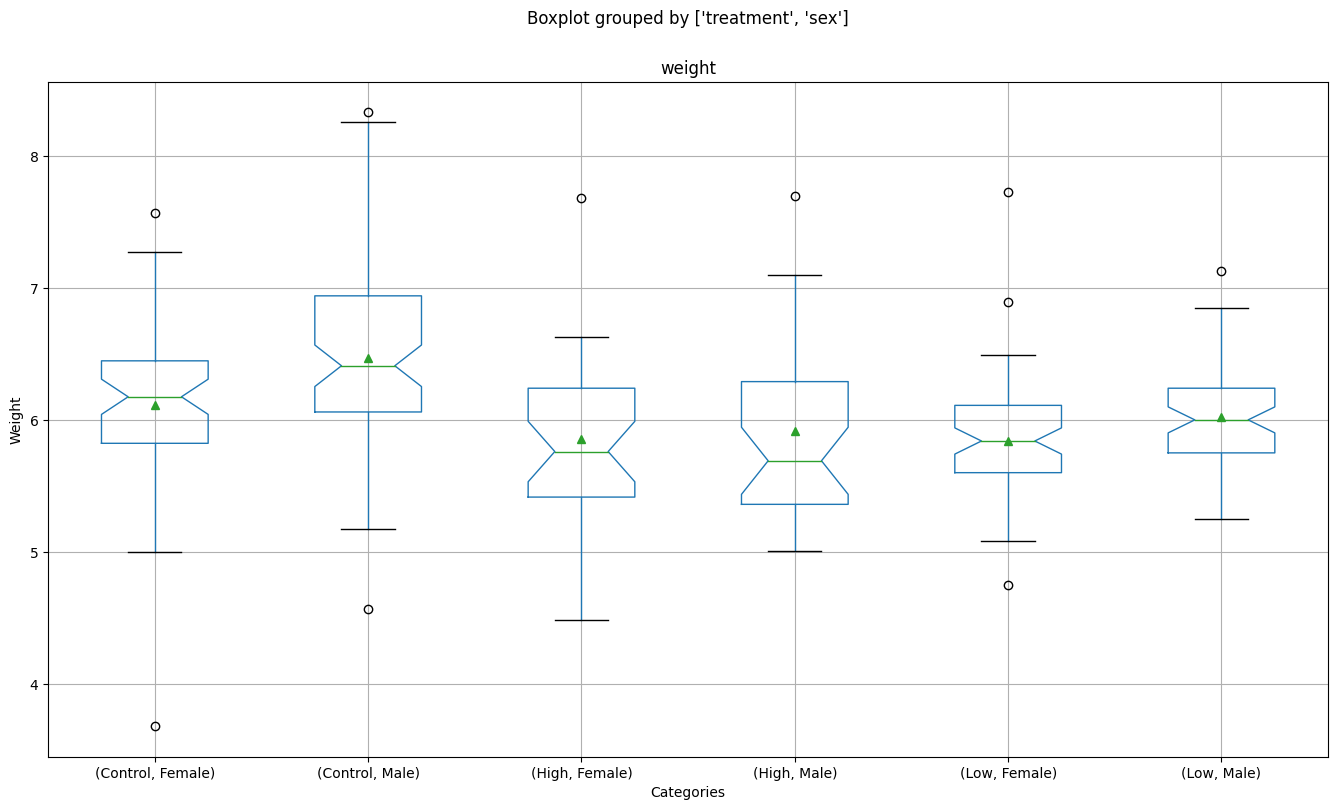

In [11]:
boxplot = df.boxplot(["weight"], by = ["treatment", "sex"],figsize = (16, 9),showmeans = True,notch = True)
boxplot.set_xlabel("Categories")
boxplot.set_ylabel("Weight");

### Random Intercept Model
Now to fit a random intercept model, recall that this type of model allows for different clusters (a group) to have different intercepts.



In [6]:
model = smf.mixedlm("weight ~ litsize+C(treatment)+C(sex,Treatment('Male'))+C(treatment):C(sex,Treatment('Male'))",df,groups="litter").fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Mixed Linear Model Regression Results
===================================================================================================
Model:                            MixedLM               Dependent Variable:               weight   
No. Observations:                 322                   Method:                           REML     
No. Groups:                       27                    Scale:                            0.1635   
Min. group size:                  2                     Log-Likelihood:                   -200.5522
Max. group size:                  18                    Converged:                        Yes      
Mean group size:                  11.9                                                             
---------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                                                 8.323    0.273 30.447 0.000  7.788  8.859
C(treatment)[T.High]                                     -0.906    0.192 -4.727 0.000 -1.282 -0.530
C(treatment)[T.Low]                                      -0.467    0.158 -2.952 0.003 -0.777 -0.157
C(sex, Treatment('Male'))[T.Female]                      -0.412    0.073 -5.625 0.000 -0.555 -0.268
C(treatment)[T.High]:C(sex, Treatment('Male'))[T.Female]  0.107    0.132  0.811 0.417 -0.151  0.366
C(treatment)[T.Low]:C(sex, Treatment('Male'))[T.Female]   0.084    0.106  0.794 0.427 -0.123  0.291
litsize                                                  -0.128    0.019 -6.845 0.000 -0.165 -0.092
litter Var                                                0.097    0.084                           
===================================================================================================

"""

In [8]:
import math
math.sqrt(0.097)

0.31144823004794875

The "litter Var" is the random effects of the cluster variable. This models the variation that is present between the litters. One can convert variance to standard deviation by taking the square root, this means that on average the litter weight can vary about 0.311 lbs (
).

The interaction between treatment and sex is non-significant, therefore this will be removed from the model and re-ran.

In [11]:
# Random Intercept Model w/out Interaction Term

model = smf.mixedlm("weight ~ litsize + C(treatment) + C(sex, Treatment('Male'))", df, groups= "litter").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                     MixedLM        Dependent Variable:        weight   
No. Observations:          322            Method:                    REML     
No. Groups:                27             Scale:                     0.1628   
Min. group size:           2              Log-Likelihood:            -198.4997
Max. group size:           18             Converged:                 Yes      
Mean group size:           11.9                                               
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            8.310    0.274 30.355 0.000  7.773  8.846
C(treatment)[T.High]                -0.859    0.182 -4.722 0.000 -1.215 -0.502
C(treatment)[T.Low]                 -0.429    0.150 -2.849 0.004 -0.723 -0.134
C(sex, Treatment('Male'))[T.Female] -0.359    0.048 -7.540 0.000 -0.452 -0.266
litsize                             -0.129    0.019 -6.863 0.000 -0.166 -0.092
litter Var                           0.097    0.085                           
==============================================================================

"""

Another useful statistic to generate is the intraclass correlation coefficient (ICC) which measures the similarity of the responses within a random effect; in the current model with 1 cluster variable, this would be the similarity in weights within the litter. The ICC can range between [0,1] where 1 indicates perfect relationship within the clusters. To calculate the ICC one takes the variance of the clustering variable (0.097) and divides it by the unexplained variance of the model (0.1628). The unexplained variance of the model can be found in the top right of the upper table labeled "scale". ICC=0.5958. This indicates that there is a moderate level of correlation between the weights within a litter.

## Random Slope Model
**No Correlation Between Random Intercept And Slopes**. Using the same data, a random slope model will be fit where the random intercepts and slopes are independent. In this model, a random slope will be allowed for the sex.

In [9]:
# Random Slope Model: Random intercepts and slopes are independent

model2 = smf.mixedlm("weight ~ litsize + C(treatment) + C(sex)", df, groups= "litter",vc_formula = {"sex" : "0 + C(sex)"}).fit()
model2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   weight   
No. Observations:     322       Method:               REML     
No. Groups:           27        Scale:                0.1565   
Min. group size:      2         Log-Likelihood:       -205.7020
Max. group size:      18        Converged:            Yes      
Mean group size:      11.9                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             7.874    0.229 34.380 0.000  7.425  8.323
C(treatment)[T.High] -0.839    0.144 -5.827 0.000 -1.121 -0.557
C(treatment)[T.Low]  -0.411    0.116 -3.526 0.000 -0.639 -0.182
C(sex)[T.Male]        0.356    0.102  3.508 0.000  0.157  0.555
litsize              -0.124    0.016 -7.915 0.000 -0.155 -0.093
sex Var               0.104    0.076                           
===============================================================

"""

The estimated variance for random sex slopes is 0.104 which is a standard deviation of 0.322. This indicates that from cluster to cluster, i.e. between litters, the sex slopes fluctuate by ± 0.322 - 0.644 (1-2 standard deviations).

## Random Slope Model
**Correlation Between Random Intercept And Slopes**. Using the same data, a random slope model will be fit where the random intercepts and slopes are correlated. In this model, a random slope will be allowed for the sex.

In [13]:
# Random Slope Model: Random intercepts and slopes are correlated

model3 = smf.mixedlm("weight ~ litsize + C(treatment) + C(sex)", df, groups= "litter",re_formula = "1 + C(sex)").fit()
model3.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM      Dependent Variable:      weight   
No. Observations:      322          Method:                  REML     
No. Groups:            27           Scale:                   0.1601   
Min. group size:       2            Log-Likelihood:          -196.3946
Max. group size:       18           Converged:               Yes      
Mean group size:       11.9                                           
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    7.806    0.263 29.672 0.000  7.291  8.322
C(treatment)[T.High]        -0.778    0.172 -4.523 0.000 -1.116 -0.441
C(treatment)[T.Low]         -0.387    0.137 -2.821 0.005 -0.656 -0.118
C(sex)[T.Male]               0.359    0.053  6.783 0.000  0.255  0.463
litsize                     -0.120    0.018 -6.637 0.000 -0.155 -0.084
litter Var                   0.063    0.074                           
litter x C(sex)[T.Male] Cov  0.028    0.044                           
C(sex)[T.Male] Var           0.013    0.062                           
======================================================================

"""

When including random intercepts and random slopes it's useful to calculate the estimated correlation coefficient between the random intercepts and random slopes. This is calculated by taking the co-variance of the random intercept (clustering variable) and random slope (random slope variable) and dividing it by the product of the variance of the random intercept and the variance of the random slope variable.
0.9784
This indicates that the litters with higher weight tend to have males that are of higher weight.

## Assumption check
Linear mixed effect models have the same assumptions as the traditional standard linear regression model. For the model diagnostics, the first model will be used which was a random intercept model with the clustering variable being litter.

## Normality
One can check for normality of the residuals graphically, a formal statistical test, or a combination of the two. If the overal sample is large one should use both since as the sample size increases so does the power of the tests, meaning that the larger the sample size the smaller of a difference the formal statistical test will detect and a significant p-value will be provided.

First let's visualize the residuals with a kernal density estimate plot and Q-Q plot.

Text(0.5, 0, 'Residuals')

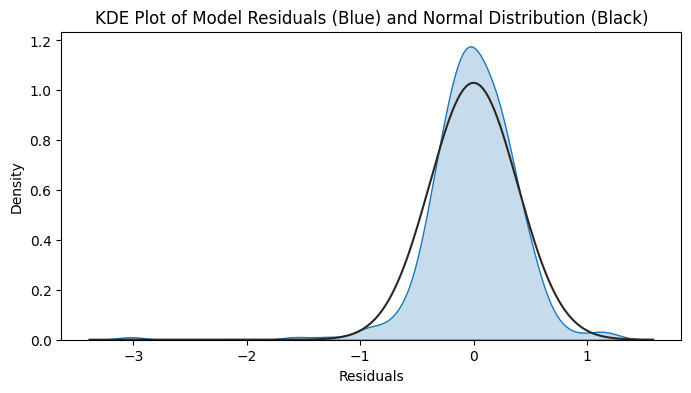

In [10]:
fig = plt.figure(figsize = (8, 4))
ax = sns.distplot(model.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)
ax.set_title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
ax.set_xlabel("Residuals")

Text(0.5, 1.0, 'Q-Q Plot')

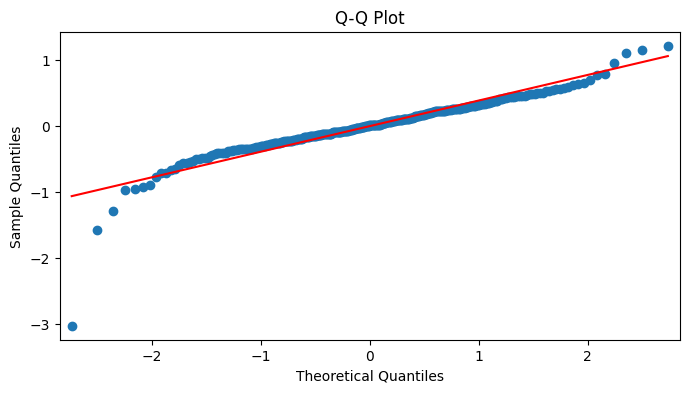

In [12]:
## Q-Q PLot

fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111)
sm.qqplot(model.resid, dist = stats.norm, line = 's', ax = ax)
ax.set_title("Q-Q Plot")

There is some deviation from normality, but it doesn't look concerning. There is an outlier, which is evident in both of the plots. How to handle the outlier is up to the researcher.

Now to formally test for normality using Shapir-Wilk test of normality.

In [18]:
labels = ["Statistic", "p-value"]

norm_res = stats.shapiro(model.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)

Statistic 0.8948183655738831
p-value 3.958863266503507e-14


The test is significant which indicates that the assumption of normality for the residuals is violated. This would suggest that the model could be adjusted to meet this assumption. Common techniques include transform variables, remove outliers, use a non-parametric approach, or rely on the central limit theorem.

## Homoskedasticity of variance
Just as with checking for normality, one can check for homoskedasticity of variance visually, with a formal test, or both. First to check for homoskedasticity visually, this can be done with an RVF Plot (residuals versus fitted values) and a boxplot.

Text(0, 0.5, 'Residuals')

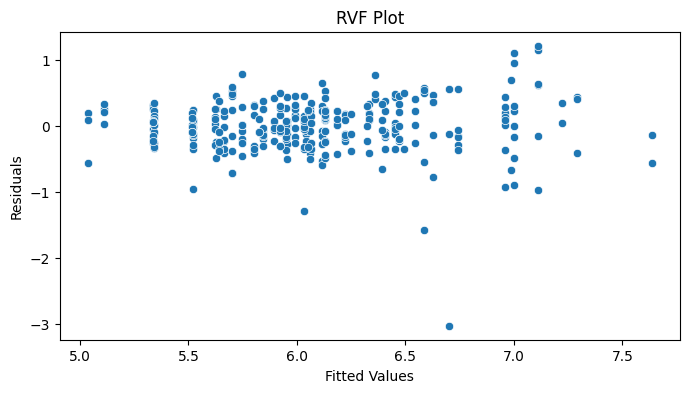

In [13]:
fig = plt.figure(figsize = (8, 4))
ax = sns.scatterplot(y = model.resid, x = model.fittedvalues)
ax.set_title("RVF Plot")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")

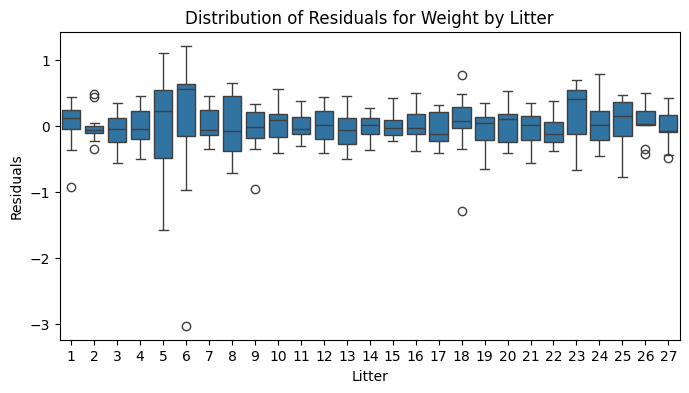

In [15]:
fig = plt.figure(figsize = (8,4))
ax = sns.boxplot(x = model.model.groups, y = model.resid)
ax.set_title("Distribution of Residuals for Weight by Litter")
ax.set_ylabel("Residuals")
ax.set_xlabel("Litter");

Now to formally test this assumption with the White’s Lagrange Multiplier Test for Heteroscedasticity

In [21]:
from statsmodels.stats.diagnostic import het_white

het_white_res = het_white(model.resid, model.model.exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)

LM Statistic 24.859526210906917
LM-Test p-value 0.0056182250407701105
F-Statistic 2.601904935064365
F-Test p-value 0.004794715230006886


Based on the visual tests, it appears that there isn't much concern about violating the assumption of homoskedasticity of the variance; however the formal testing indicates this assumption is violated.

To address this, one could assess the model for outliers, or transform variables.

## Ejemplo 2

The synthetic dataset contains student-level variables (student_id, study_hours) and school-level variables (school_id, school_funding), along with the generated dependent variable (test_scores).

In [2]:
# Step 1: Generate a Synthetic Dataset
np.random.seed(42)
num_schools = 30
num_students = 300

# School-level data (Level 2)
schools = pd.DataFrame({
    "school_id": np.arange(num_schools),
    "school_funding": np.random.uniform(50000, 200000, num_schools)  # Random school funding
})

# Student-level data (Level 1)
students = pd.DataFrame({
    "student_id": np.arange(num_students),
    "school_id": np.random.choice(schools['school_id'], num_students),  # Assign students to schools
    "study_hours": np.random.uniform(1, 5, num_students)  # Random study hours
})

# Generating a target variable 'test_scores' influenced by both levels
# Let's assume both study hours and school funding positively affect test scores
students = students.merge(schools, on="school_id")
students['test_scores'] = 50 + students['study_hours'] * 3 + students['school_funding'] * 0.0001 + np.random.normal(0, 5, num_students)


In [3]:
# Step 2: Define and Fit the HLM2
# Random intercept model with student-level and school-level predictors
md = sm.MixedLM.from_formula("test_scores ~ study_hours", groups="school_id", re_formula="~study_hours", data=students)
mdf = md.fit()

mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM     Dependent Variable:     test_scores
No. Observations:      300         Method:                 REML       
No. Groups:            30          Scale:                  26.2411    
Min. group size:       6           Log-Likelihood:         -951.1178  
Max. group size:       19          Converged:              Yes        
Mean group size:       10.0                                           
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   60.528    1.237 48.918 0.000 58.103 62.953
study_hours                  3.267    0.334  9.792 0.000  2.613  3.921
school_id Var               23.092    2.398                           
school_id x study_hours Cov -2.647    0.555                           
study_hours Var              1.176    0.173                           
======================================================================

"""

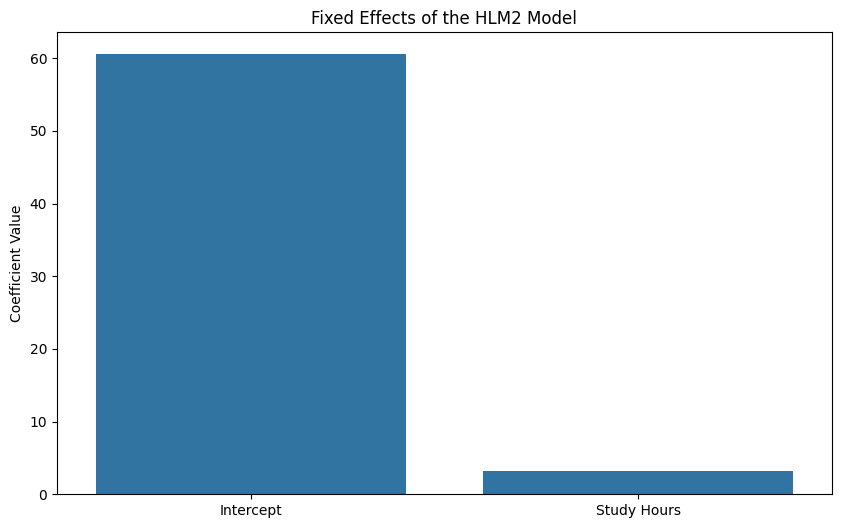

In [4]:
# Step 3: Visualization
# Plotting the fixed effects
plt.figure(figsize=(10, 6))
sns.barplot(x=["Intercept", "Study Hours"], y=mdf.fe_params)
plt.title('Fixed Effects of the HLM2 Model')
plt.ylabel('Coefficient Value')
plt.show()

In [5]:
students.head()

,student_id,school_id,study_hours,school_funding,test_scores
0,0,18,1.372411,114791.752796,76.545423
1,84,18,3.045370,114791.752796,66.573793
2,135,18,3.951588,114791.752796,69.135329
3,153,18,2.735407,114791.752796,66.688432
4,195,18,4.213924,114791.752796,63.501468


### Fixed Effects:
**Intercept**: The average test score is about 60.528 when study hours are zero. This value is influenced by the average school funding across all schools.

**Study Hours Coefficient**: For each additional hour of study, the test score increases by approximately 3.267 points.

### Random Effects:
The variance components show the variability in intercepts and slopes across different schools.

- The positive coefficient for study hours suggests a direct positive relationship between study hours and test scores.
- The model accounts for the variability in test scores both within and across schools.
- The random effects indicate that the impact of study hours on test scores varies from school to school.